|평가문항 |상세기준 |
|---|---|
|1. 인물모드 사진을 성공적으로 제작하였다.|아웃포커싱 효과가 적용된 인물모드 사진과 동물 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.|
|2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.|인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.|
|3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.|semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 이유와 함께 제시하였다.|

## 프로젝트: 인물 모드 문제점 찾기

package 와 pre-trained model 다운받기

In [1]:
# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함 (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)
# urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
# pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구

# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인
import os
import urllib
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt


from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


sementation 모델 다운 받기

In [2]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
os.makedirs(model_dir, exist_ok=True)
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x798f2e7a7910>)

### utility function & variable setting

In [3]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

label2id = {label:i for i, label in enumerate(LABEL_NAMES)}
id2label = {i:label for i, label in enumerate(LABEL_NAMES)}

In [4]:
def colormap(rgb2bgr=False):
    # 아래 코드를 이해하지 않아도 좋습니다
    # PixelLib에서 그대로 가져온 코드입니다
    # 주목해야 할 것은 생상 코드 결과물이예요!

    #컬러맵 만들기 
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    # 주의: RGB colormap
    if rgb2bgr:
        r = colormap[:,0].copy()
        b = colormap[:,2].copy()
        colormap[:,0] = b
        colormap[:,2] = r
        return colormap
    else:
        return colormap

def make_mask(output, seg_color):
    # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
    # seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
    # cmap 값을 변경하면 다른 색상으로 확인이 가능함
    seg_map = np.all(output==seg_color, axis=-1) 
    return seg_map

def make_blur_img(img_orig, k_size = None, gain=1):
    
    if k_size is None:
        # gain 이 고려된 동적 kernel size 선정 방식
        k_size = max(1, int(np.sqrt(img_orig.shape[0]**2 + img_orig.shape[1]**2)/100*gain))
    
    img_orig_blur = cv2.blur(img_orig, (k_size, k_size))
    
    return img_orig_blur

def show_segmentation(segvalues, output):
    #segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
    plt.imshow(output)
    plt.title(f'output')
    plt.show()
    #segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
    for class_id in segvalues['class_ids']:
        
        seg_map = make_mask(output, seg_color = colormap(rgb2bgr=True)[class_id])
        plt.imshow(seg_map, cmap='gray')
        plt.title(f'id:{class_id} {LABEL_NAMES[class_id]}')
        plt.show()

def show_image(img_bgr, title='', figsize=(10,10)):
    plt.figure(figsize=figsize)
    # plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    if title:
        plt.title
    plt.show()
    
def show_mask_on_image(img_orig, seg_map):
    # 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
    img_show = img_orig.copy()

    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255

    # 255와 0을 적당한 색상으로 바꿔봅니다
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # 원본 이미지와 마스크를 적당히 합쳐봅니다
    # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
    show_image(img_show)

### Step 1. 인물모드 직접 해 보기
- 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 
    - 최소 3장
    - 인물이 주인공이 아닌, 고양이, 강아지, 의자에 대한 아웃포커싱 사진도 만들어 보았다. (시맨틱 세그멘테이션 스텝)
    - 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성. 
    여러분만의 환상적인 사진을 만들어 보면 어떨까요?


원본 이미지
<div style="width:80%; margin:0 auto; float:left">
<img src="images/person_in_paint.png" alt="images/dog-grass.png" width="50%"/>
<img src="images/person_in_paint2.png" alt="images/dog-grass.png" width="50%"/>
<img src="images/dog-grass.png" alt="images/dog-grass.png" width="50%"/>
<img src="images/puppy.png" alt="images/dog-grass.png" width="50%"/>
<img src="images/whale.png" alt="images/dog-grass.png" width="50%"/>    
</div>



#### Step 1-1.a. 그림에서 사람찾아 배경 흐리게 하기 (step-by-step)

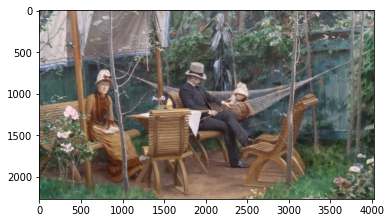

In [5]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/person_in_paint.png'  
pip_bgr = cv2.imread(img_path)
img_orig = pip_bgr.copy()
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

sementation 결과 분석을 위한 이미지 출력

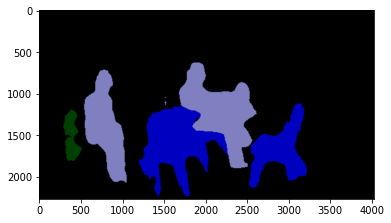

0 background


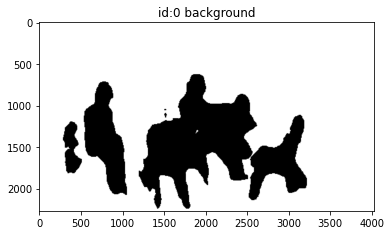

9 chair


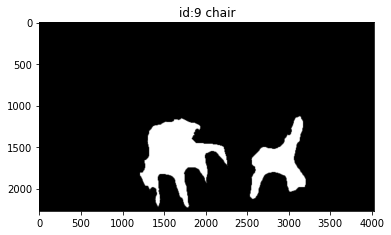

15 person


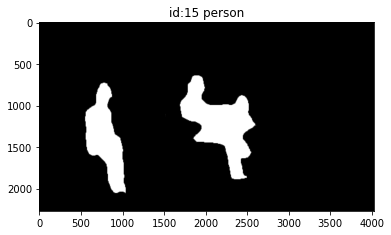

16 pottedplant


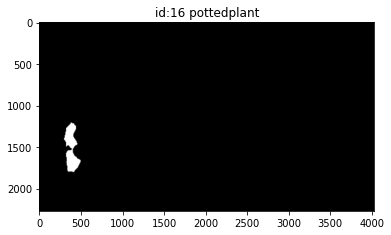

In [7]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(class_id, LABEL_NAMES[class_id])
    seg_map = make_mask(output, seg_color = colormap(rgb2bgr=True)[class_id])
    plt.imshow(seg_map, cmap='gray')
    plt.title(f'id:{class_id} {LABEL_NAMES[class_id]}')
    plt.show()

전경 부분 모음

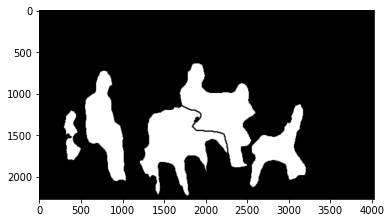

In [8]:
fg_indices = [9, 15, 16]
seg_cum_map = np.zeros_like(output).sum(-1)
for class_id in fg_indices:
    seg_cum_map += make_mask(output, seg_color=colormap(rgb2bgr=True)[class_id])

plt.imshow(seg_cum_map, cmap='gray')
plt.show()
    

사람 부분 색칠하기

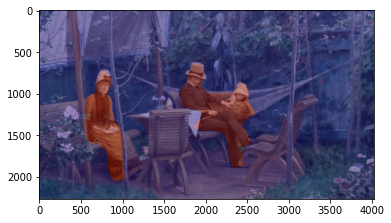

In [9]:
seg_map = make_mask(output, seg_color = colormap(rgb2bgr=True)[15])

# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

흐린 이미지 만들기

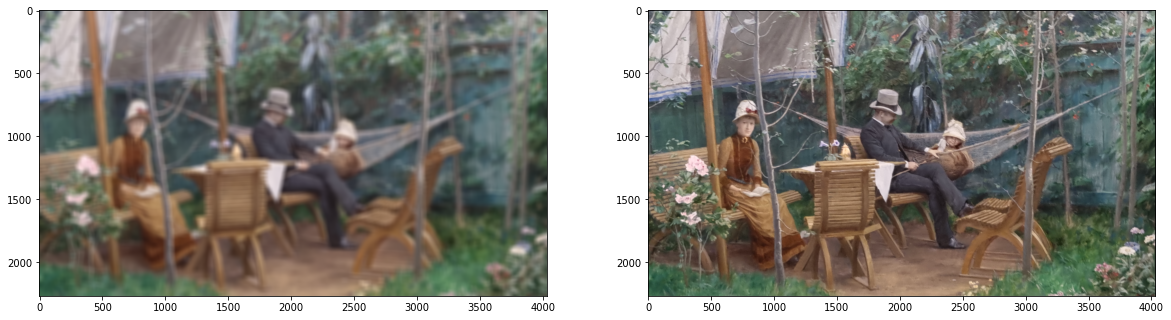

In [10]:
img_orig_blur = make_blur_img(img_orig, gain = 1)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

전경, 배경 마스크. 전경, 배경 cropped blurred image 출력하기

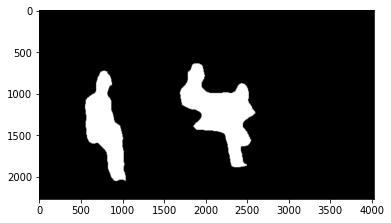

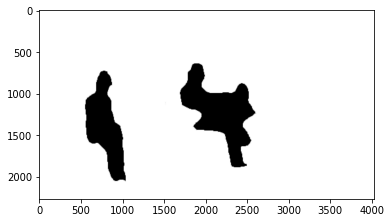

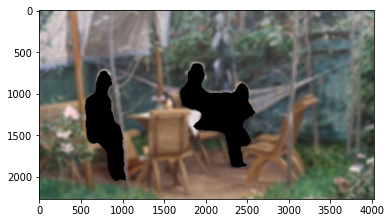

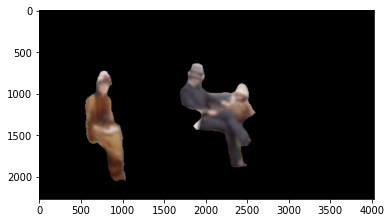

In [11]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # channel 수가 1 에서 3으로 변경됨
plt.imshow(img_mask_color)
plt.show()
# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)
plt.imshow(img_bg_mask)
plt.show()

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
img_fg_blur = cv2.bitwise_and(img_orig_blur, img_mask_color)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_fg_blur, cv2.COLOR_BGR2RGB))
plt.show()

사람을 제외한 배경 흐리게 하여 통합 출력하기

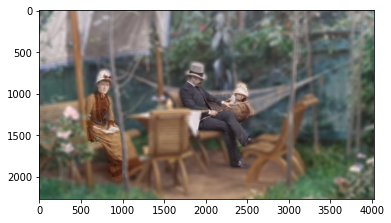

In [12]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### Step 1-2. 모델 준비하고 함수화 하기

In [13]:
class Seg:
    def __init__(self):
        model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
        model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
        model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
        self.model = model
        
    def _process_image(self, img_path, 
                       bg_indices=[0], 
                       fg_indices=list(set(id2label.keys()) - {0}), 
                       debug=False):
        """
            img_path: 이미지 파일 경로
            bg_indices: background mask 생성에 사용될 class_id 리스트 -> 합집합으로 생성됨
            fg_indices: foreground mask 생성에 사용될 class_id 리스트 -> 합집합으로
            debug: debug 모드 활성화 flag
        """
        # 이미지 경로에서 이미지 불러오기
        img_orig =  cv2.imread(img_path)
        # 준비된 모델을 사용해서 이미지 경로의 이미지에서 segmentation 수행하기
        # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용 
        segvalues, output = self.model.segmentAsPascalvoc(img_path) 
        
        if debug: show_segmentation(segvalues, output)  # debug 모드에서 각 class 별 픽셀 보여주기
        
        # output 은 color 정보 channel size = 3 이므로 1로 줄여주기 위해서 sum 을 사용했다.
        seg_map = np.zeros_like(output).sum(-1)  # Initialization
        
        # fg_indices 에서 bg_indices 로 지정된 부분을 제외한다.
        fg_indices = list(set(fg_indices) - set(bg_indices))
        # fg_indices 안에 있는 class_id 에 대한 mask 들을 union 시켜 하나의 mask 를 만든다.
        for class_id in fg_indices:
            seg_map += make_mask(output, seg_color=colormap(rgb2bgr=True)[class_id])
        
        # True과 False인 값을 각각 255과 0으로 바꿔줍니다
        img_mask = seg_map.astype(np.uint8) * 255
        img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) 
        # img_mask -> img_mask_color. channel 수가 1 에서 3으로 변경됨
        
        # cv2.bitwise_not(): 이미지가 반전됨
        # img_mask_color: 전경은 255 배경은 0
        # img_bg_mask: 배경은 255 전경은 0
        img_bg_mask = cv2.bitwise_not(img_mask_color)

        return img_orig, img_mask_color, img_bg_mask
    
    def chromakey(self, img_path, bg_path, 
                  chromakey_part='bg', figsize=(20,20),
                  **kwargs):
        img_orig, img_fg_mask, img_bg_mask = self._process_image(
            img_path, **kwargs)
        
        # 원본 이미지의 blur 버전을 만든다. 
        # gain: blur 를 얼마나 심하게 할지 (0, image_size]
        img_bg = cv2.imread(bg_path) 
        w,h = img_orig.shape[1],img_orig.shape[0]
        img_bg = cv2.resize(img_bg, (w,h))

        # np.where(조건, 참일때, 거짓일때)
        # 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
        # 아닌 영역은 크로마키 이미지 값을 사용합니다.
        if chromakey_part=='bg':
            img_concat = np.where(img_bg_mask==255, img_bg, img_orig)
        elif chromakey_part=='fg':
            img_concat = np.where(img_fg_mask==255, img_bg, img_orig)
        else:
            raise NotImplemented

        # BGR 형식을 RGB 형식으로 변경하여 출력
        show_image(img_concat, figsize=figsize)
    
    def blur_image(self, 
                   img_path, 
                   blur_part='bg', figsize=(20,20),
                   **kwargs):
        
        img_orig, img_fg_mask, img_bg_mask = self._process_image(
            img_path, **kwargs)
        
        # 원본 이미지의 blur 버전을 만든다. 
        # gain: blur 를 얼마나 심하게 할지 (0, image_size]
        img_orig_blur = make_blur_img(img_orig, gain = 1)        

        # np.where(조건, 참일때, 거짓일때)
        # 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
        # 아닌 영역은 블러된 이미지 값을 사용합니다.
        if blur_part=='bg':
            img_concat = np.where(img_bg_mask==255, img_orig_blur, img_orig)
        elif blur_part=='fg':
            img_concat = np.where(img_fg_mask==255, img_orig_blur, img_orig)
        else:
            raise NotImplemented

        # BGR 형식을 RGB 형식으로 변경하여 출력
        show_image(img_concat, figsize=figsize)

In [14]:
my_seg = Seg()

#### Step 1-2.a. 그림에서 사람찾아 배경 흐리게 하기 ( do with function )

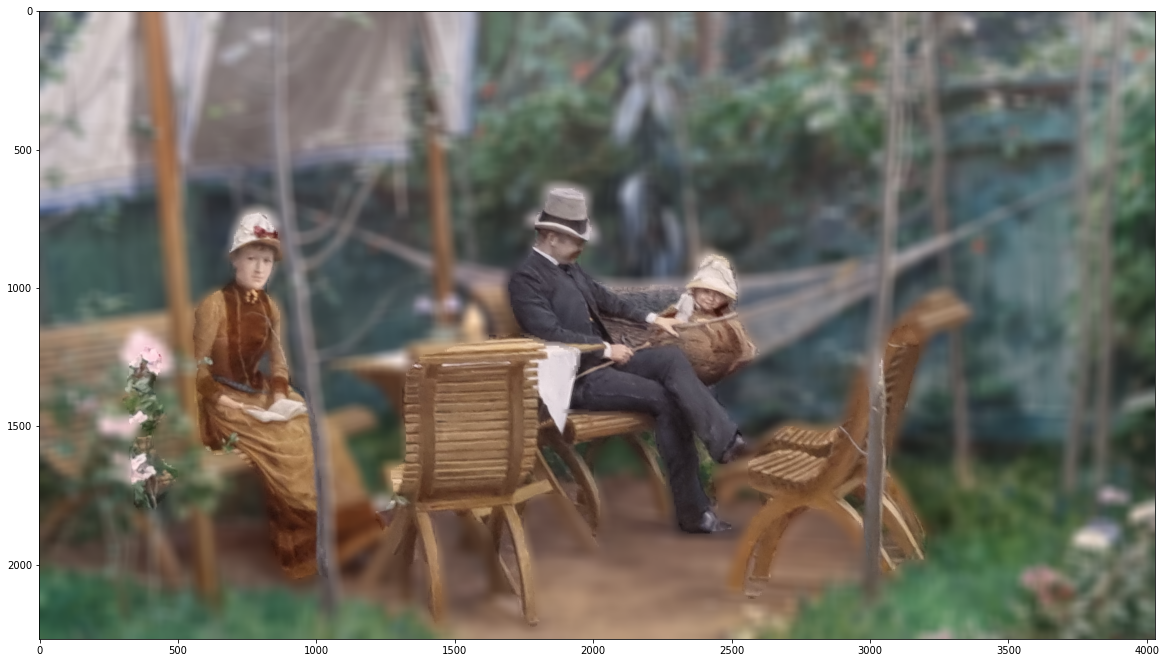

In [15]:
my_seg.blur_image(img_path= os.getenv('HOME')+'/aiffel/human_segmentation/images/person_in_paint.png'  ,
           fg_indices=[9,15, 16])

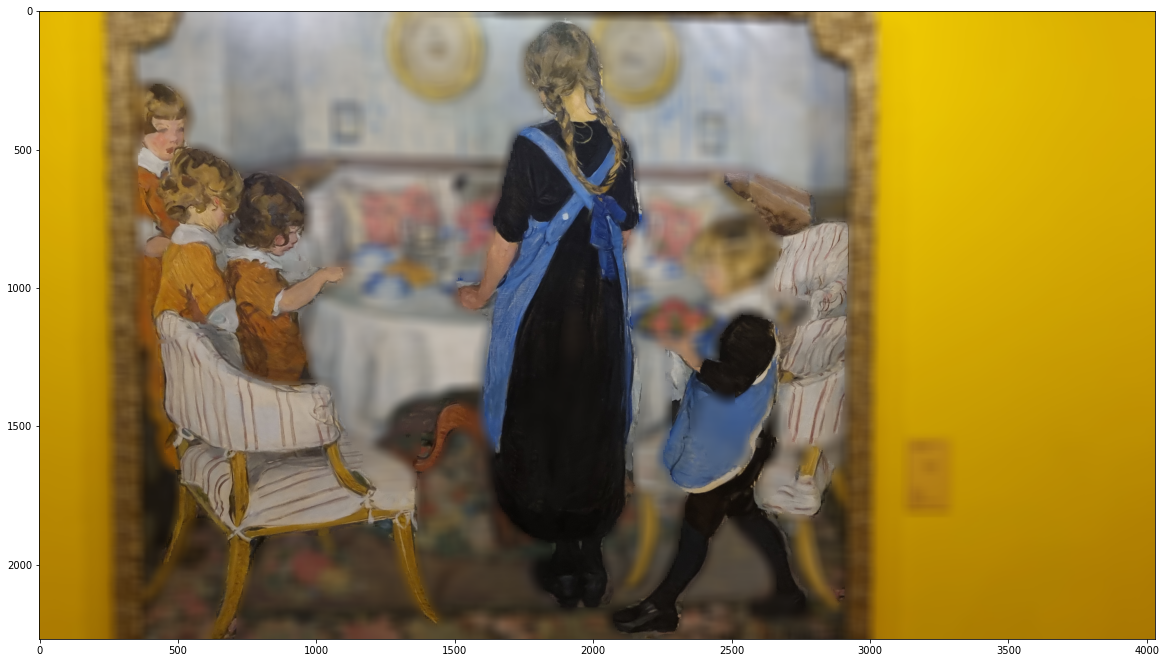

In [16]:
my_seg.blur_image(img_path= os.getenv('HOME')+'/aiffel/human_segmentation/images/person_in_paint2.png',
           fg_indices=[9,15],
            debug=False,)

#### Step 1-2.b.  강아지 사진 배경 블러처리 하기 ( do with function )

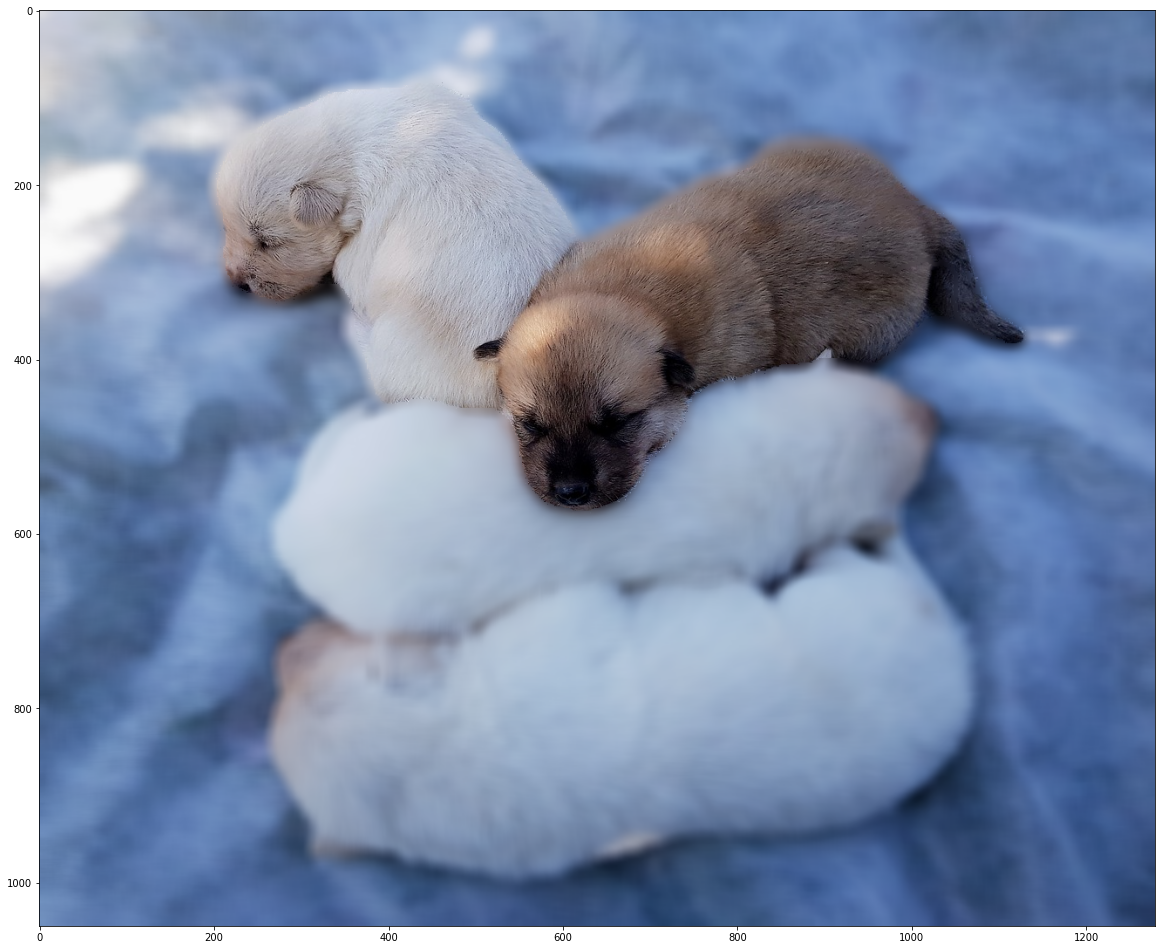

In [20]:
my_seg.blur_image(
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/puppy.png',
    fg_indices = [8, 12], # cat and dog
    debug=False)

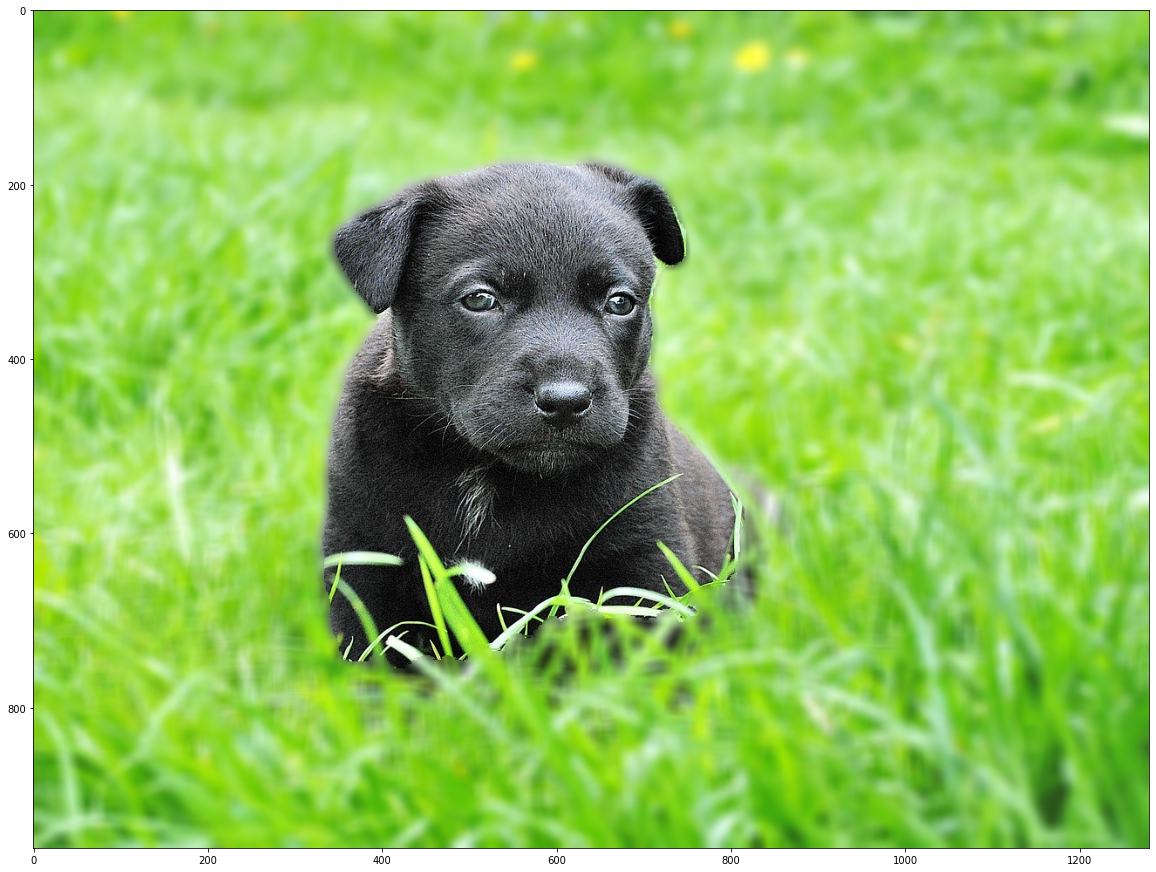

In [21]:
my_seg.blur_image(
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog-grass.png',
    fg_indices = [12], # dog
    debug=False)

#### Step 1-2.c. 배경 크로마키 하기 ( do with function )

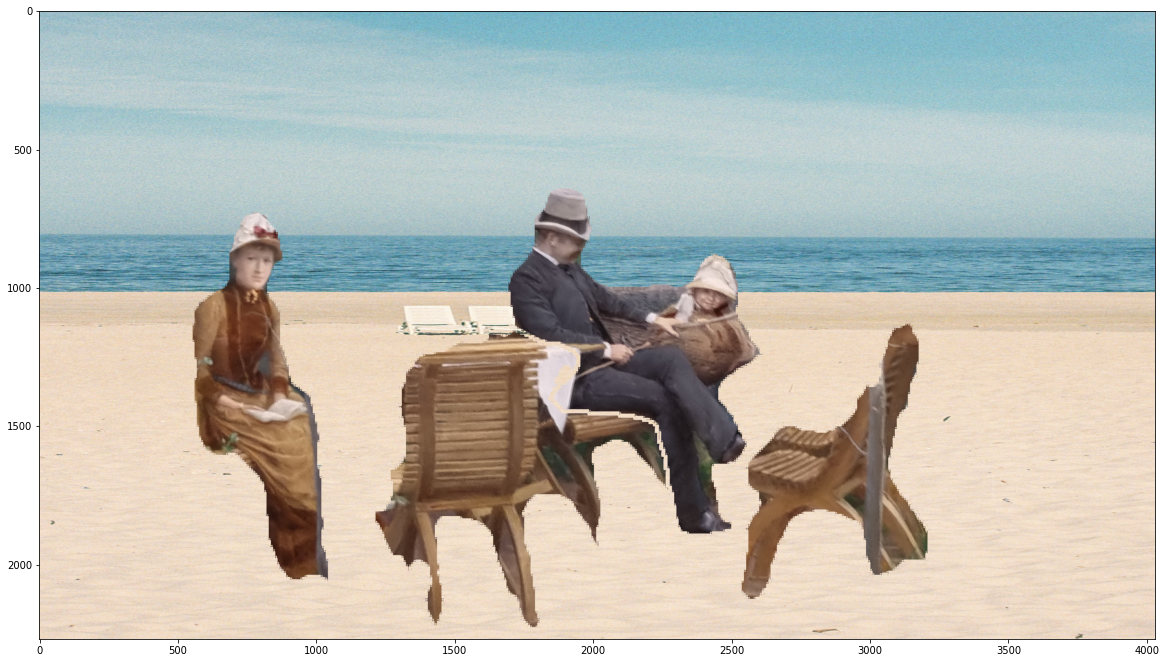

In [17]:
my_seg.chromakey(
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/person_in_paint.png',
    bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/beach.png',
    bg_indices = [0,16],  # 배경을 명시적으로 지정해주었다.
    debug=False)

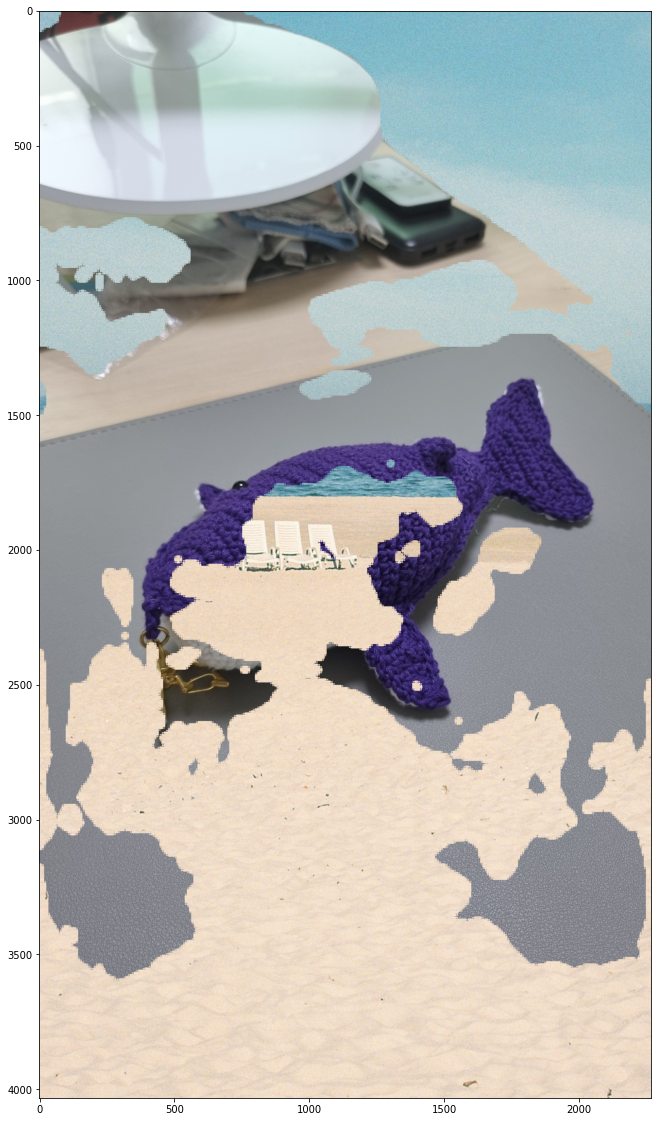

In [22]:
my_seg.chromakey(
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/whale.png',
    bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/beach.png',
    bg_indices = [0,16],  # 배경을 명시적으로 지정해주었다.
    debug=False)

### Step 2. 사진에서 문제점 찾기

#### Step 2-1. 어떤 문제가 있는지 찾아서 사진에 표시

<img src="images/analysis_lecturer.png" alt="images/dog-grass.png" width="80%"/>

#### Step 2-2. 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시
- 표시한 이미지들을 jupyter notebook에 포함하여 제출

<img src="images/analysis_person_in_paint1.png" alt="images/dog-grass.png" width="80%"/>
<img src="images/analysis_person_in_paint2.png" alt="images/dog-grass.png" width="80%"/>
<img src="images/analysis_dog-grass.png" alt="images/dog-grass.png" width="80%"/>
<img src="images/analysis_puppy.png" alt="images/dog-grass.png" width="80%"/>
<img src="images/analysis_chromakey.png" alt="images/dog-grass.png" width="80%"/>
<img src="images/analysis_whale.png" alt="images/dog-grass.png" width="80%"/>


### Step 3. 해결 방법을 제안해 보기

앞서 발견한 문제점을 해결할 방안을 정리하여 제안해 보자


#### Step 3-1. 인접한 pixel 에 대해서 semantic segmentation 이 분절되는 문제
- 픽셀 별 hard classification 만을 활용하지 않고, Uncertainty 도 출력하여 (e.g. 픽셀별로 class의 probability를 출력하도록 변경) 모호한 부분에 대해서는 완화된 효과적용을 할 수 있도록 하여 보다 사용자 편의를 높일 수 있다.
- 예를 들어 특정 픽셀에 대해서 모델의 uncertainty 가 특정 값을 넘어간다면, unknown 픽셀로 넘기고, 이에 대해 또 다른 class로 여기고 blur 처리를 중간 단계만 적용하게 하거나, 해당 픽셀에는 두 이미지를 모두 적용 (addWeighted) 할 수 있을 것이다. 
- uncertainty를 측정하는 방법에는
    - 각 픽셀에 대해서 얼마나 모호하게 예측을 하고 있는지 output Probability 의 entropy 를 측정하는 가장 간단한 방법이 있다.
    - 또는 Bayesian Neural Network 등을 사용하여 model 의 예측값에 대한 uncertainty 를 측정할 수 있다. 하지만 계산 속도가 느려진다는 단점이 있다.

#### Step 3-2. 학습시 사용되지 않은 class 에 대한 semantic segmentation 이 필요한 경우 낮은 정확도 문제
- 지도학습을 사용한 경우, 학습시에 사용한 segmentation mask (class)에대한 예측 확률만을 출력할 수 있다. 또한 사용자 환경에서 학습시 보지 못한 class 의 물체가 등장한 경우, 예측하지 못하거 예측 성능이 낮다.
    - 사람과 interaction 하는 모델을 사용. 포토샵에서 인접한 색을 포함하여 few-shot learning을 활용한 예측 방법
        - [Few-Shot Semantic Segmentation with Prototype Learning](https://www.semanticscholar.org/paper/Few-Shot-Semantic-Segmentation-with-Prototype-Dong-Xing/17d3f0abff5569768e890afb8633d5f29bb9c289): 

### 회고

- 배운점
    - blur 할 때, 커널 사이즈는 정수값이어야 한다.
    - 
- 아쉬운점
    - 시간관리를 잘하지 못했다.
    - 가능한 문제해결 방법들을 많이 찾아보지 못해서 아쉬웠다.
- 느낀점
    - 재미있었다. 
    - 이미지 파일을 다루는건 체력적으로 힘들다. (코딩 외에 할게 많다.)
- 어려웠던 점
    - 크로마키를 만들 때, 고래 인형이 잘 인식되지 않았고, 이를 해결하려고 시도하느라 시간을 많이 소요했다.